## Create a graph visualization of the analysis schema and/or the user JSON

- use the dict from the json?
    - can I use the nesting of the dicts to infer relationships and order?
- use the pydantic classes and the type hints?
    - can I use type hints and ID's to infer relationships?

### Test 1: Using dict from user JSON to create a graph

In [28]:
import analysis_schema.run_analysis
import networkx

In [29]:
viz_schema = analysis_schema.run_analysis.visualize("../analysis_schema/pydantic_schema_example.json")

In [30]:
# It's a dict!
print(type(viz_schema))

<class 'dict'>


In [31]:
print(viz_schema)

{'$schema': './yt_analysis_schema.json', 'Data': {'FileName': './IsolatedGalaxy/galaxy0030/galaxy0030', 'DatasetName': 'IG_Testing'}, 'Plot': [{'ProjectionPlot': {'Axis': 'y', 'FieldNames': {'field': 'temperature', 'field_type': 'gas'}, 'FontSize': 30, 'DataSource': {'sphere': {'Center': [0.6, 0.6, 0.6], 'Radius': 0.2}}}}]}


In [32]:
print(viz_schema.keys())
print()
# do I need all items in the dict, or just the keys?
print(viz_schema["Data"])

dict_keys(['$schema', 'Data', 'Plot'])

{'FileName': './IsolatedGalaxy/galaxy0030/galaxy0030', 'DatasetName': 'IG_Testing'}


In [33]:
# example test schema

test_schema = {"$schema": "yt_schema", "Data" :
               [{'FileName': './IsolatedGalaxy/galaxy0030/galaxy0030', 'DatasetName': 'IG_Testing'}]}

# : {"Projection_Plot": [3,4,5]}

In [34]:
Graph = networkx.Graph()

In [46]:

parent_child_list = list()

# where to add the recursion?
# list is the problem - use index 0
# what about where a dict is the value? - call the recursive function
# how to connect the parent to every other parent in a nested dict?
# for the second child in a nested dict, need to connect it to the right parent


def network_input(schema: dict, carry_over_parent=None):
    parent_child_temp = list()
    
    for index, key in enumerate(schema):
        print(index, key)
        
        if index == 0:
            if carry_over_parent is not None:
                parent_child_temp.append(carry_over_parent)
            nested_type = isinstance(schema[key], list)
            if nested_type is True:
                flat_schema = schema[key][0]
            parent_node = key
            parent_child_temp.append(parent_node)
            nested_type = schema[key]
            nested_flag = isinstance(nested_type, dict)
            if nested_flag is True:
                print(key, schema[key])
                network_input(nested_type, parent_child_temp[1])
            
        if index != 0:
            # append the children
            if carry_over_parent is not None:
                parent_child_temp.insert(0, carry_over_parent)
            parent_child_temp.append(key)
            nested_type = isinstance(schema[key], list)
            if nested_type is True:
                flat_dict = dict()
                # when I flatten the list then the key that found it is lost
                flat_dict[key] = schema[key][0]
                nested_type = flat_dict[key]
                nested_flag = isinstance(nested_type, dict)
                if nested_flag is True:
                    network_input(flat_dict[key], key)
                    
            schema_list = isinstance(schema, list)
            nested_type = schema[key]
            nested_flag = isinstance(nested_type, dict)
            if nested_flag is True:
                print(key, schema[key])
                network_input(schema[key], parent_child_temp[1])

            if len(parent_child_temp) == 1:
                parent_child_temp.insert(0, parent_node)
                parent_child_list.append(parent_child_temp)
                parent_child_temp = list()
        
        if len(parent_child_temp) == 2:
            # add edges to graph here
            parent_child_list.append(parent_child_temp)
            parent_child_temp = list()
    
    return parent_child_list
        
    

In [47]:
graph = network_input(viz_schema)
graph

0 $schema
1 Data
Data {'FileName': './IsolatedGalaxy/galaxy0030/galaxy0030', 'DatasetName': 'IG_Testing'}
0 FileName
1 DatasetName
2 Plot
0 ProjectionPlot
ProjectionPlot {'Axis': 'y', 'FieldNames': {'field': 'temperature', 'field_type': 'gas'}, 'FontSize': 30, 'DataSource': {'sphere': {'Center': [0.6, 0.6, 0.6], 'Radius': 0.2}}}
0 Axis
1 FieldNames
FieldNames {'field': 'temperature', 'field_type': 'gas'}
0 field
1 field_type
2 FontSize
3 DataSource
DataSource {'sphere': {'Center': [0.6, 0.6, 0.6], 'Radius': 0.2}}
0 sphere
sphere {'Center': [0.6, 0.6, 0.6], 'Radius': 0.2}
0 Center
1 Radius


[['Data', 'FileName'],
 ['Data', 'DatasetName'],
 ['$schema', 'Data'],
 ['ProjectionPlot', 'Axis'],
 ['FieldNames', 'field'],
 ['FieldNames', 'field_type'],
 ['ProjectionPlot', 'FieldNames'],
 ['ProjectionPlot', 'FontSize'],
 ['sphere', 'Center'],
 ['sphere', 'Radius'],
 ['DataSource', 'sphere'],
 ['ProjectionPlot', 'DataSource'],
 ['Plot', 'ProjectionPlot'],
 ['$schema', 'Plot']]

In [48]:
Graph.add_edges_from(graph)

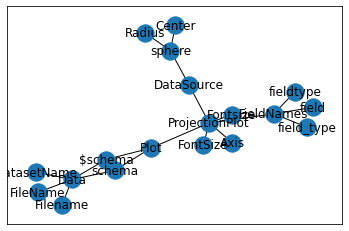

In [49]:
networkx.draw_networkx(Graph)

In [50]:
Graph.add_edges_from([["schema", "Data"], 
                      ["schema", "Plot"], 
                      ["Data", "Filename"], 
                      ["Data", "DatasetName"],
                      ["Plot", "ProjectionPlot"],
                      ["ProjectionPlot", "Axis"],
                      ["ProjectionPlot", "FieldNames"],
                      ["FieldNames", "field"],
                      ["FieldNames", "fieldtype"],
                      ["ProjectionPlot", "Fontsize"],
                      ["ProjectionPlot", "DataSource"],
                      ["DataSource", "sphere"],
                      ["sphere", "Center"],
                      ["sphere", "Radius"]
                     ])

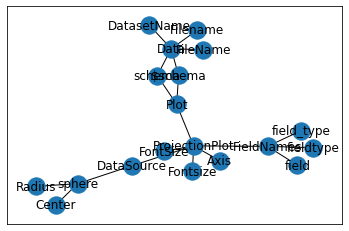

In [51]:
graph = networkx.draw_networkx(Graph)

### Test 2: Visaulizing the Analysis Schema

In [52]:
Analysis_Schema_Graph = networkx.Graph()

In [53]:
analysis_schema_json = analysis_schema.run_analysis.visualize("../analysis_schema/yt_analysis_schema.json")
print(analysis_schema_json.items())

dict_items([('title', 'yt Schema Model for Descriptive Visualization and Analysis'), ('description', 'Create a model in the form of a json schema, using the yt data classes. As values\nare added to the file referencing the schema, the function `run` with be called\nrecursively to acccess nested yt elements and run the yt code.\n\nThe run function iterates through the attributes of the class and runs this values\nentered for those attributes and puts the output into a list. This list will be\niterated through to render and display the output.'), ('type', 'object'), ('properties', {'Data': {'$ref': '#/definitions/Dataset'}, 'Plot': {'title': 'Plot', 'type': 'array', 'items': {'$ref': '#/definitions/Visualizations'}}}), ('definitions', {'Dataset': {'title': 'Dataset', 'description': 'The dataset to load. Filename (fn) must be a string.\n\nRequired fields: Filename', 'type': 'object', 'properties': {'FileName': {'title': 'Filename', 'description': 'A string containing the (path to the file

In [55]:
analysis_schema_graph = network_input(analysis_schema_json)
analysis_schema_graph
networkx.draw_networkx(Analysis_Schema_Graph)

# I forogt about the definitions in the schema. 
# I'll have to add a way to move into that section to grab the correct attributes and make them nodes.

0 title
1 description
2 type
3 properties
properties {'Data': {'$ref': '#/definitions/Dataset'}, 'Plot': {'title': 'Plot', 'type': 'array', 'items': {'$ref': '#/definitions/Visualizations'}}}


IndexError: list index out of range

In [27]:
Graph.add_edges_from(analysis_schema_json)


NetworkXError: Edge tuple title must be a 2-tuple or 3-tuple.

### Visualizing Schemas
- this is great for small JSON files, but how do we deal with bigger, unreadable schemas?
- interactive viz? To pan, zoom or hide nodes?